# Analyse the initial state relying on WOA09 dataset to find density inversion

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib import rcParams
from mpl_toolkits.basemap import Basemap
from fsspec.implementations.local import LocalFileSystem
fs = LocalFileSystem()

%matplotlib inline

In [2]:
import gsw as gsw

In [3]:
from kerchunk.hdf import SingleHdf5ToZarr 
from kerchunk.combine import MultiZarrToZarr

import fsspec
import json
import intake

import dask
import dask_hpcconfig
from distributed import Client
from dask.distributed import Client, LocalCluster


ModuleNotFoundError: No module named 'kerchunk'

In [3]:
cluster = dask_hpcconfig.cluster("datarmor", **{})
client = Client(cluster)
cluster.scale(jobs=1)

/home1/datawork/ctalandi/conda-env/Jupyter-Dask/lib/python3.11/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


>> Function definition START

In [3]:
def Arc_Bat(ztype='isol1000') :

        locpath=='/data0/project/drakkar/CONFIGS/CREG025.L75/GRID/'
        locfile='CREG025.L75_domain_cfg.nc'
        fieldbat=Dataset(locpath+locfile)
        lon  = np.squeeze(fieldbat.variables['nav_lon'])
        lat  = np.squeeze(fieldbat.variables['nav_lat'])
        My_var = np.squeeze(fieldbat.variables['bathy_meter'])

        spval = 0.
        My_var= np.ma.masked_where(My_var <= spval,My_var)

        if ztype == 'isol1000' :
                vmin=1000. ; vmax=2000.
                contours=[1000.]
                limits=[vmin,vmax]
                myticks=[1000.]
        elif ztype == 'isol1500' :
                vmin=1500. ; vmax=2000.
                contours=[1500.]
                limits=[vmin,vmax]
                myticks=[1500.]
        elif ztype == 'isomonarc' :
                vmin=500. ; vmax=4000.
                contours=[500.,2000.,4000.]
                limits=[vmin,vmax]
                myticks=[500.,2000.,4000.]
        elif ztype == 'isol500' :
                vmin=500. ; vmax=500.
                contours=[500.]
                limits=[vmin,vmax]
                myticks=[500.]
        else:
                vmin=0. ; vmax=8000.
                contours=[100.,500.,1000.,2000.,3000.,3500.,4000.]
                limits=[vmin,vmax]
                myticks=[100.,500.,1000.,2000.,3000.,3500.,4000.]

        #
        #rcParams['text.latex.unicode']=True
        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')
        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])
        pal = plt.cm.get_cmap('binary')
        X,Y = m(lon,lat)

        # contour (optional)
        CS2 = m.contour(X, Y, My_var, linewidths=0.5,levels=contours, colors='black', alpha=1.)
        plt.clabel(CS2, CS2.levels, inline=True, fmt='%.0f', fontsize=3)

        return m, X, Y


In [4]:
def Arc_plot(lon,lat,tab,contours,limits,myticks=None,name=None,zmy_cblab=None,zmy_cmap=None,filename='test.pdf',zvar=None):
        #
# Les 2 lignes suivantes posent un probleme a l'execution lie a LaTex ....
#       rcParams['text.usetex']=True
#       rcParams['text.latex.unicode']=True
        #rcParams['font.family']='serif'

        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')

        if zvar == 'sivolu' or zvar == 'siconc'  or zvar == 'ssh' or zvar == 'socurl' :
                zfontsize=10.
        else:
                zfontsize=6.

        if zvar != 'Bathy' :
                m.drawparallels(np.arange(-90.,91.,5.),labels=[False,False,False,False], size=zfontsize, linewidth=0.3)
                m.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True], size=zfontsize, latmax=90.,linewidth=0.3)
                m.fillcontinents(color='grey',lake_color='white')

        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])

        if zmy_cmap != None :
                pal = zmy_cmap
        else:
                pal = plt.cm.get_cmap('coolwarm')
                #pal = plt.cm.get_cmap('terrain')

        X,Y = m(lon,lat)
        C = m.contourf(X,Y,tab,contours,cmap=pal,norm=norm,extend='both')
        if zvar == 'ssh':
                CS=m.contour(X, Y, tab, linewidths=0.5, levels=npy.arange(limits[0],limits[1],5.), colors='k', alpha=0.4)

        ############################################################################################################
        ############################################################################################################
        moorplot=0
        if moorplot == 1 :
                bx_ARCB={'name':'B'  ,'lon_min':-150.,'lon_max':-150.,'lat_min':78.,'lat_max':78.}
                bx_ARCM={'name':'M1' ,'lon_min': 125.,'lon_max': 125.,'lat_min':78.,'lat_max':78.}
                bx_EURA={'name':'EUR','lon_min':  60.,'lon_max':  60.,'lat_min':85.,'lat_max':85.}

                All_box=[bx_ARCB,bx_EURA]
                for box in All_box:
                        lats = [box['lat_min'],box['lat_max']]
                        lons = [box['lon_min'],box['lon_max']]
                        x,y = m(lons,lats)
                        m.scatter(x,y,3,marker='o', color='r')
                        #m.plot(x,y,linewidth=2, color='g')
        ############################################################################################################
        ############################################################################################################

        # colorbar      
        if myticks is None:
                cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8)
        else:
                if zvar == 'votemper' or zvar == 'vosaline' or zvar == 'sivolu' :
                        cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8,drawedges=True)
                else:
                        cbar = plt.colorbar(C,format='%.0f',orientation='vertical',shrink=0.8,drawedges=True)

                cbar.set_label(zmy_cblab,fontsize=zfontsize)
                cl = plt.getp(cbar.ax, 'ymajorticklabels')
                plt.setp(cl, fontsize=zfontsize)

        plt.title(name,fontsize=zfontsize)

        return m

In [5]:
def awtmax_depth (temp,sal,zdim,deptht,ztime=None, zmask=None):
    #%%time 
    if ztime != None : 
        mask = (sal > 33.5) 
        ztemp = temp.where(mask)

    #%%time 
    temp_filled = (ztemp.fillna(-10)).compute() #replace nans with absurd temperature values
    depth_map = temp_filled.argmax(dim=zdim,skipna=True) 
    temp_map = temp_filled.max(dim=zdim,skipna=True)

    temp_map=temp_map.where(temp_map != -10)
    depth_map=depth_map.where(depth_map != -10)
    #print(zmask.shape)
    if zmask.any != None : depth_map=depth_map.where(zmask != 0)
    
    # Need to get now the true depth, not the index
    ind_awdepth=np.int32(depth_map)
    new_depth=[]
    for it in ind_awdepth.flat:
        if it < 0 :
            new_depth.append(-999)
        else:
            new_depth.append(deptht[it])

    true_depth=np.array(new_depth)
    true_depth=np.where(true_depth == -999,np.nan, true_depth)
    # Hard coded dimensions of the CREG12.L75 configuration 
    #reshape_true_depth=np.reshape(true_depth,(1801, 1580))
    # Hard coded dimensions of the CREG025.L75 configuration 
    if ztime != None : 
        reshape_true_depth=np.reshape(true_depth,(ztime,603, 528))
        # Transform the numpy array into a data array
        final_true_depth=xr.DataArray(reshape_true_depth,dims=['time_counter','y','x'])
    else: 
        reshape_true_depth=np.reshape(true_depth,(603, 528))
        # Transform the numpy array into a data array
        final_true_depth=xr.DataArray(reshape_true_depth,dims=['y','x'])

    
    return temp_map, final_true_depth

In [6]:
def ArcticZoom_map(zyear,infld,zmy_min=-10,zmy_max=10,CASE=None,zmap='Spectral_r'):
    # Plot the 12 months of a given year 

    fig, axes = plt.subplots(3, 4, figsize=(20,15)) 

    for i, ax in enumerate(axes.flat):
        if i < 9: 
            mm='0'+str(i+1) 
        else : 
            mm=str(i+1)
        infld.isel(time_counter=i).isel(y=slice(300,550),x=slice(200,400)).plot(ax=ax,vmin=zmy_min,vmax=zmy_max,cmap=zmap)   
        #ds_ICE['siconc'].sel(time_counter=str(year)+'-'+mm).isel(y=slice(300,550),x=slice(200,400))[0,:,:].plot.contour(ax=ax,levels=[0.15],colors='g')   
        fieldbat['bathy_meter'].isel(t=0,y=slice(300,550),x=slice(200,400)).plot.contour(ax=ax,levels=[500.,2000.],colors='k',alpha=0.8)
        # The indices in the following are taken in the new framework set by the slices just above
        zbx_SVAL={'name':'SVA','lon_min':125,'lon_max':125,'lat_min':50,'lat_max':50}
        zbx_BANN={'name':'BAN','lon_min':147,'lon_max':147,'lat_min':100,'lat_max':100}
        zbx_AANN={'name':'AAN','lon_min':154,'lon_max':154,'lat_min':125,'lat_max':125}
        zbx_KARA={'name':'KAR','lon_min':155,'lon_max':155,'lat_min':150,'lat_max':150}
        zbx_ULAP={'name':'ULA','lon_min':164,'lon_max':164,'lat_min':178,'lat_max':178}
        zbx_LAPT={'name':'LAP','lon_min':155,'lon_max':155,'lat_min':200,'lat_max':200}
        zbx_BGYR={'name':'LAP','lon_min':10,'lon_max':10,'lat_min':175,'lat_max':175}
        All_box=[zbx_SVAL,zbx_BANN,zbx_AANN,zbx_KARA,zbx_ULAP,zbx_LAPT,zbx_BGYR]
        for box in All_box:
            ax.scatter(box['lon_min'],box['lat_min'],20,marker='o', color='r')

        ax.set_title(CASE+'  month:'+str(zyear)+mm)
    return

In [7]:
# Define a function used to clean data from the Monitoring 
def clean_AM_AWtmax_depth(fldtoclean,tmask2D):
    fldtoclean=xr.where(tmask2D==0., np.nan,fldtoclean)
    fldtoclean=xr.where(fldtoclean >=999., np.nan,fldtoclean)
    return fldtoclean

>> Function definition END

# CREG025.L75  Grid

In [8]:
GRIDPATH='/data0/project/drakkar/CONFIGS/CREG025.L75/GRID/'
ds_grd=xr.open_dataset(GRIDPATH+'CREG025.L75-NEMO420_mesh_mask.nc',drop_variables=["x", "y"] )
ds_grd
tmask2D=ds_grd['tmask'].isel(nav_lev=0,time_counter=0)

# CREG025.L75  Bathymetry

In [9]:
locpath='/data0/project/drakkar/CONFIGS/CREG025.L75/GRID/'
locfile='CREG025.L75_domain_cfg.nc'
fieldbat=xr.open_dataset(locpath+locfile)
fieldbat

<xarray.Dataset>
Dimensions:       (y: 603, x: 528, z: 75, t: 1)
Dimensions without coordinates: y, x, z, t
Data variables: (12/42)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    nav_lev       (z) float32 ...
    time_counter  (t) float64 ...
    jpiglo        int32 ...
    jpjglo        int32 ...
    ...            ...
    e3w_0         (t, z, y, x) float64 ...
    e3uw_0        (t, z, y, x) float64 ...
    e3vw_0        (t, z, y, x) float64 ...
    bottom_level  (t, y, x) int32 ...
    top_level     (t, y, x) int32 ...
    bathy_meter   (t, y, x) float32 ...
Attributes:
    file_name:  domain_cfg.nc
    TimeStamp:  08/07/2019 18:14:20 +0200

# Read the full years input Data processed by the Arctic Monitoring

In [10]:
DATA_PATH='/data0/project/drakkar/CONFIGS/CREG025.L75/GRID/'
filein='CREG025.L75-NEMO420_OCEinit_gridT.nc'
ds_init=xr.open_dataset(DATA_PATH+filein,drop_variables=["x", "y"])
ds_init

<xarray.Dataset>
Dimensions:       (nav_lev: 75, time_counter: 1, y: 603, x: 528)
Coordinates:
  * nav_lev       (nav_lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time_counter  (time_counter) float32 0.0
Dimensions without coordinates: y, x
Data variables: (12/18)
    votemper      (time_counter, nav_lev, y, x) float64 ...
    vosaline      (time_counter, nav_lev, y, x) float64 ...
    sossheig      (time_counter, y, x) float64 ...
    vozocrtx      (time_counter, nav_lev, y, x) float64 ...
    vomecrty      (time_counter, nav_lev, y, x) float64 ...
    vovecrtz      (time_counter, nav_lev, y, x) float64 ...
    ...            ...
    sowaflup      (time_counter, y, x) float64 ...
    sohefldo      (time_counter, y, x) float64 ...
    soshfldo      (time_counter, y, x) float64 ...
    soicecov      (time_counter, y, x) float64 ...
    sozotaux      (time_counter, y, x) float64 ...
    sometauy      (time_counter, y, x) float64 ...
Attributes:
    file_name:  output.init.nc
    TimeStamp:  24/10/2022 15:19:27 -0000

In [11]:
DATA_PATH='/data0/project/drakkar/CONFIGS/CREG025.L75/GRID/'
filein='CREG025.L75-NEMO420DIN_OCEinit_gridT_SM10.nc'
ds_sm=xr.open_dataset(DATA_PATH+filein,drop_variables=["x", "y"])
ds_sm

<xarray.Dataset>
Dimensions:       (nav_lev: 75, time_counter: 1, y: 603, x: 528)
Coordinates:
  * nav_lev       (nav_lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time_counter  (time_counter) float32 0.0
Dimensions without coordinates: y, x
Data variables: (12/20)
    votemper      (time_counter, nav_lev, y, x) float64 ...
    vosaline      (time_counter, nav_lev, y, x) float64 ...
    sossheig      (time_counter, y, x) float64 ...
    vozocrtx      (time_counter, nav_lev, y, x) float64 ...
    vomecrty      (time_counter, nav_lev, y, x) float64 ...
    vovecrtz      (time_counter, nav_lev, y, x) float64 ...
    ...            ...
    soshfldo      (time_counter, y, x) float64 ...
    soicecov      (time_counter, y, x) float64 ...
    sozotaux      (time_counter, y, x) float64 ...
    sometauy      (time_counter, y, x) float64 ...
    vovvldep      (time_counter, nav_lev, y, x) float64 ...
    vovvle3t      (time_counter, nav_lev, y, x) float64 ...

In [12]:
ds_init.coords['nav_lat']=fieldbat['nav_lat']
ds_init.coords['nav_lon']=fieldbat['nav_lon']

In [7]:
# identify the first 1500m depth
ds_init.nav_lev[0:50]

<xarray.DataArray 'nav_lev' (nav_lev: 50)>
array([5.057600e-01, 1.555855e+00, 2.667682e+00, 3.856280e+00, 5.140361e+00,
       6.543034e+00, 8.092519e+00, 9.822750e+00, 1.177368e+01, 1.399104e+01,
       1.652532e+01, 1.942980e+01, 2.275762e+01, 2.655830e+01, 3.087456e+01,
       3.574020e+01, 4.118002e+01, 4.721189e+01, 5.385064e+01, 6.111284e+01,
       6.902168e+01, 7.761116e+01, 8.692943e+01, 9.704131e+01, 1.080303e+02,
       1.200000e+02, 1.330758e+02, 1.474062e+02, 1.631645e+02, 1.805499e+02,
       1.997900e+02, 2.211412e+02, 2.448906e+02, 2.713564e+02, 3.008875e+02,
       3.338628e+02, 3.706885e+02, 4.117939e+02, 4.576256e+02, 5.086399e+02,
       5.652923e+02, 6.280260e+02, 6.972587e+02, 7.733683e+02, 8.566790e+02,
       9.474479e+02, 1.045854e+03, 1.151991e+03, 1.265861e+03, 1.387377e+03],
      dtype=float32)
Coordinates:
  * nav_lev  (nav_lev) float32 0.5058 1.556 2.668 ... 1.266e+03 1.387e+03

In [24]:
LAPT_sec={'name':"Laptev" ,'jmin': 470,'jmax':520 ,'imin':340}

In [11]:
print(ds_init['nav_lev'].sel(nav_lev=200.,method='nearest'))

<xarray.DataArray 'nav_lev' ()>
array(199.78996, dtype=float32)
Coordinates:
    nav_lev  float32 199.8


In [21]:
CASE='NEMO420DIN'   ; freq='1m'

year=1979
DATA_PATH='/data0/project/drakkar/CONFIGS/CREG025.L75/TMPDIR/'
ds_DIN = xr.open_dataset(DATA_PATH+'CREG025.L75-'+CASE+'_y'+str(year)+'m01.'+freq+'_gridW_SM3.nc')  
ds_DINT= xr.open_dataset(DATA_PATH+'CREG025.L75-'+CASE+'_y'+str(year)+'m01.'+freq+'_gridT_SM3.nc',drop_variables=['nav_lat','nav_lon'])  

In [11]:
ds_DINT

<xarray.Dataset>
Dimensions:               (deptht: 75, axis_nbounds: 2, time_counter: 1,
                           y: 603, x: 528)
Coordinates:
  * deptht                (deptht) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    time_centered         (time_counter) object ...
  * time_counter          (time_counter) object 1979-01-16 12:00:00
Dimensions without coordinates: axis_nbounds, y, x
Data variables:
    deptht_bounds         (deptht, axis_nbounds) float32 ...
    time_centered_bounds  (time_counter, axis_nbounds) object ...
    time_counter_bounds   (time_counter, axis_nbounds) object ...
    e3t                   (time_counter, deptht, y, x) float32 ...
    votemper              (time_counter, deptht, y, x) float32 ...
    vosaline              (time_counter, deptht, y, x) float32 ...
    ssh                   (time_counter, y, x) float32 ...
    mldkz5                (time_counter, y, x) float32 ...
    mldr10_1              (time_counter, y, x) float32 ...
    rhop_sig0             (time_counter, deptht, y, x) float32 ...
    botpres               (time_counter, y, x) float32 ...
Attributes:
    name:              /home1/scratch/ctalandi/CREG025.L75-NEMO420DIN-XIOS.1/...
    description:       ocean T grid variables
    title:             ocean T grid variables
    Conventions:       CF-1.6
    timeStamp:         2025-Mar-14 10:35:18 GMT
    uuid:              9bbdf598-1de0-4093-94ac-993623bedb6a
    start_date:        19790101
    output_frequency:  1mo
    CONFIG:            CREG025.L75
    CASE:              NEMO420DIN

>>> ## Compute the density

In [13]:
# Define a pressure from depth
pressure=gsw.p_from_z(-ds_init['nav_lev'],ds_init['nav_lat'])

In [14]:
# Conversion from potential temperature and Practical Salinity to Conservative Temperature and Absolute Salinity 

In [15]:
ds_init['SA']=gsw.conversions.SA_from_SP(ds_init['vosaline'],pressure,ds_init['nav_lon'],ds_init['nav_lat'])
ds_init['CT']=gsw.conversions.CT_from_pt(ds_init['SA'],ds_init['votemper'])
ds_init['SA_sm']=gsw.conversions.SA_from_SP(ds_sm['vosaline'],pressure,ds_init['nav_lon'],ds_init['nav_lat'])
ds_init['CT_sm']=gsw.conversions.CT_from_pt(ds_init['SA_sm'],ds_sm['votemper'])

In [16]:
ds_init

<xarray.Dataset>
Dimensions:       (nav_lev: 75, time_counter: 1, y: 603, x: 528)
Coordinates:
  * nav_lev       (nav_lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time_counter  (time_counter) float32 0.0
    nav_lat       (y, x) float32 ...
    nav_lon       (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables: (12/22)
    votemper      (time_counter, nav_lev, y, x) float64 ...
    vosaline      (time_counter, nav_lev, y, x) float64 ...
    sossheig      (time_counter, y, x) float64 ...
    vozocrtx      (time_counter, nav_lev, y, x) float64 ...
    vomecrty      (time_counter, nav_lev, y, x) float64 ...
    vovecrtz      (time_counter, nav_lev, y, x) float64 ...
    ...            ...
    sozotaux      (time_counter, y, x) float64 ...
    sometauy      (time_counter, y, x) float64 ...
    SA            (time_counter, nav_lev, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0
    CT            (time_counter, nav_lev, y, x) float64 0.01528 ... 0.01528
    SA_sm         (time_counter, nav_lev, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0
    CT_sm         (time_counter, nav_lev, y, x) float64 0.01528 ... 0.01528
Attributes:
    file_name:  output.init.nc
    TimeStamp:  24/10/2022 15:19:27 -0000

In [164]:
# Compute the density
ds_init['sigma0']=gsw.density.sigma0(ds_init['SA'],ds_init['CT'])

In [17]:
# Compute the Brunt-Vaissalla frequency
N2,p_imd=gsw.Nsquared(ds_init['SA'].isel(time_counter=0).values,\
                           ds_init['CT'].isel(time_counter=0).values,\
                           pressure,axis=0)

N2_sm,p_imd=gsw.Nsquared(ds_init['SA_sm'].isel(time_counter=0).values,\
                           ds_init['CT_sm'].isel(time_counter=0).values,\
                           pressure,axis=0)

In [18]:
# Build a 2D map to see how many instabilities occur on each water column
num_N2=np.where(N2 < 0.,1.,0.)
# Remove the grid points in the a pseudo ML
num_N2[0:10,:,:]=0. 
# Remove the grid points below 1500m to make a clean comparison with WOA09 initial dataset 
num_N2[50::,:,:]=0. 
ds_init['Instab']=(('y','x'),np.sum(num_N2,axis=0))
ds_init['Instab']=xr.where(tmask2D==0,np.nan,ds_init['Instab'])


# Build a 2D map to see how many instabilities occur on each water column
num_N2_sm=np.where(N2_sm < 0.,1.,0.)
# Remove the grid points in the a pseudo ML
num_N2_sm[0:10,:,:]=0. 
# Remove the grid points below 1500m to make a clean comparison with WOA09 initial dataset 
num_N2_sm[50::,:,:]=0. 
ds_init['Instab_sm']=(('y','x'),np.sum(num_N2_sm,axis=0))
ds_init['Instab_sm']=xr.where(tmask2D==0,np.nan,ds_init['Instab_sm'])

In [19]:
ds_init['CT']=xr.where(ds_grd['tmask'].isel(time_counter=0)==0.,np.nan,ds_init['CT'])
ds_init['SA']=xr.where(ds_grd['tmask'].isel(time_counter=0)==0.,np.nan,ds_init['SA'])
ds_init['CT_sm']=xr.where(ds_grd['tmask'].isel(time_counter=0)==0.,np.nan,ds_init['CT_sm'])
ds_init['SA_sm']=xr.where(ds_grd['tmask'].isel(time_counter=0)==0.,np.nan,ds_init['SA_sm'])

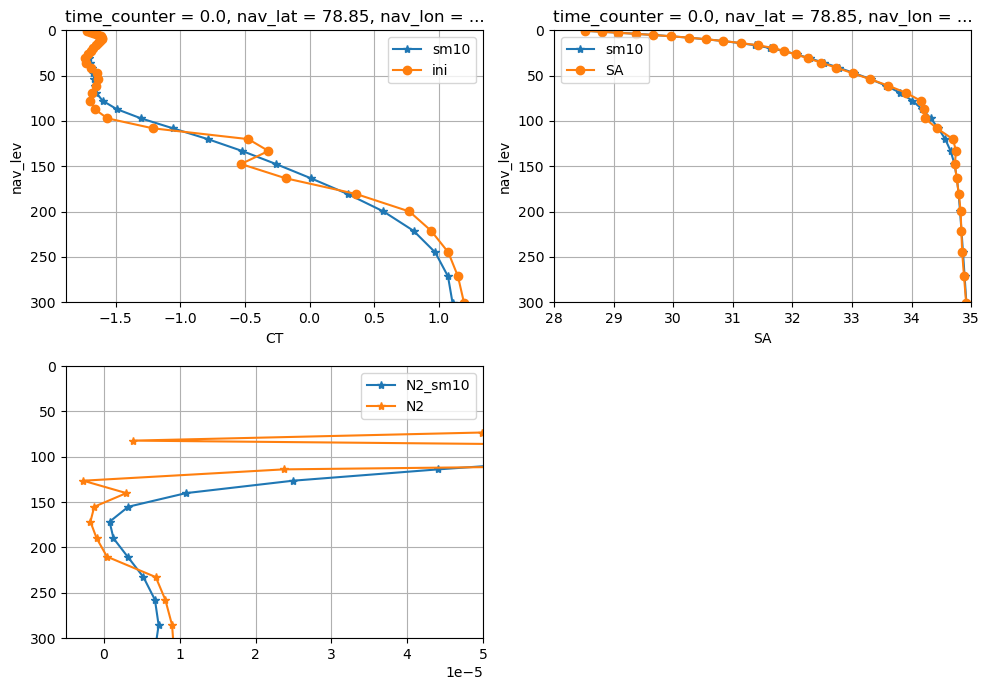

In [22]:
plt.figure(figsize=(10,7))

loc_x=340  ;  loc_y=497

plt.subplot(221)
ds_init['CT_sm'].isel(x=loc_x,y=loc_y).plot(y='nav_lev',marker='*',label='sm10')
ds_init['CT'].isel(x=loc_x,y=loc_y).plot(y='nav_lev',marker='o',label='ini')
plt.ylim([300,0.])
plt.grid(True)
plt.legend()

plt.subplot(222)
ds_init['SA_sm'].isel(x=loc_x,y=loc_y).plot.line(y='nav_lev',marker='*',label='sm10')
ds_init['SA'].isel(x=loc_x,y=loc_y).plot(y='nav_lev',marker='o',label='SA')
plt.xlim([28,35])
plt.ylim([300,0.])
plt.grid(True)
plt.legend()

if True:
    plt.subplot(223)
    plt.plot(N2_sm[:,loc_y,loc_x],ds_DIN['depthw'].isel(depthw=slice(0,74)),marker='*',label='N2_sm10')
    plt.plot(N2[:,loc_y,loc_x],ds_DIN['depthw'].isel(depthw=slice(0,74)),marker='*',label='N2')
    plt.xlim([-0.5e-5,5e-5])
    plt.ylim([300,0.])
    plt.grid(True)
    plt.legend()

if False:
    plt.subplot(224)
    #ds_DIN['logavt'].isel(x=loc_x,y=loc_y).plot.line(y='depthw',marker='*')
    ds_DIN['logavt'].isel(x=340,y=slice(480,500)).plot(y='depthw',vmin=-15.,vmax=3.,cmap='Spectral_r')
    #plt.xlim([-15,4])
    plt.ylim([300,0.])
    plt.grid(True)

if False:
    plt.subplot(224)
    ds_init['sigma0'].isel(x=loc_x,y=loc_y).plot.line(y='nav_lev',marker='*')
    plt.xlim([27.6,28])
    plt.ylim([300,0.])
    plt.grid(True)

plt.tight_layout()

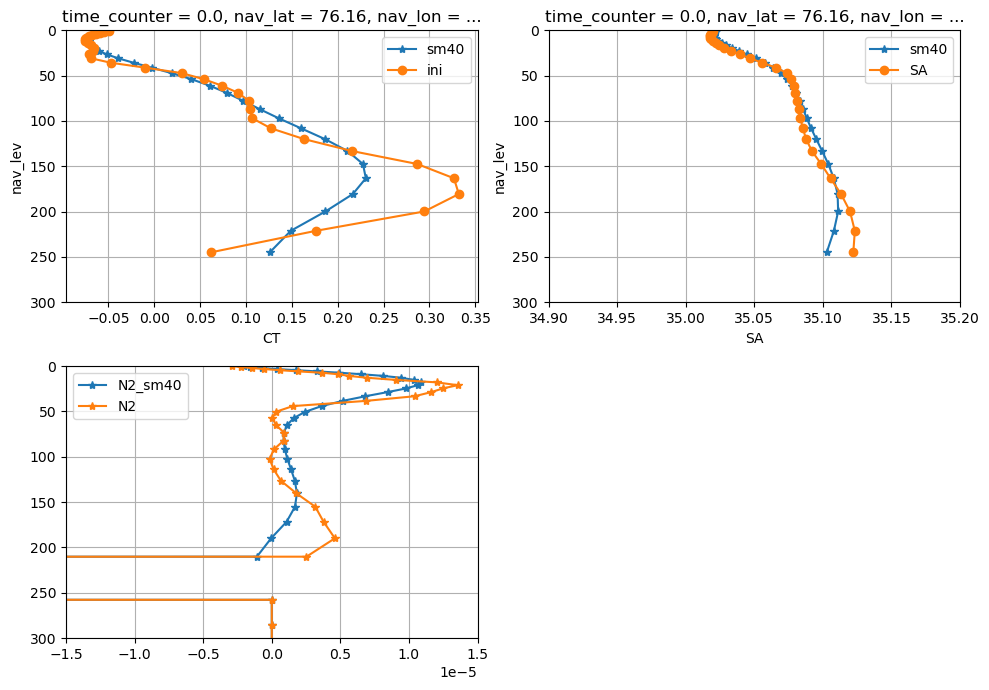

In [23]:
plt.figure(figsize=(10,7))

loc_x=390  ;  loc_y=350

plt.subplot(221)
ds_init['CT_sm'].isel(x=loc_x,y=loc_y).plot(y='nav_lev',marker='*',label='sm40')
ds_init['CT'].isel(x=loc_x,y=loc_y).plot(y='nav_lev',marker='o',label='ini')
plt.ylim([300,0.])
plt.grid(True)
plt.legend()

plt.subplot(222)
ds_init['SA_sm'].isel(x=loc_x,y=loc_y).plot.line(y='nav_lev',marker='*',label='sm40')
ds_init['SA'].isel(x=loc_x,y=loc_y).plot(y='nav_lev',marker='o',label='SA')
plt.xlim([34.9,35.2])
plt.ylim([300,0.])
plt.grid(True)
plt.legend()

if True:
    plt.subplot(223)
    plt.plot(N2_sm[:,loc_y,loc_x],ds_DIN['depthw'].isel(depthw=slice(0,74)),marker='*',label='N2_sm40')
    plt.plot(N2[:,loc_y,loc_x],ds_DIN['depthw'].isel(depthw=slice(0,74)),marker='*',label='N2')
    plt.xlim([-1.5e-5,1.5e-5])
    plt.ylim([300,0.])
    plt.grid(True)
    plt.legend()

if False:
    plt.subplot(224)
    #ds_DIN['logavt'].isel(x=loc_x,y=loc_y).plot.line(y='depthw',marker='*')
    ds_DIN['logavt'].isel(x=340,y=slice(480,500)).plot(y='depthw',vmin=-15.,vmax=3.,cmap='Spectral_r')
    #plt.xlim([-15,4])
    plt.ylim([300,0.])
    plt.grid(True)

if False:
    plt.subplot(224)
    ds_init['sigma0'].isel(x=loc_x,y=loc_y).plot.line(y='nav_lev',marker='*')
    plt.xlim([27.6,28])
    plt.ylim([300,0.])
    plt.grid(True)

plt.tight_layout()

In [59]:
ds_init

<xarray.Dataset>
Dimensions:       (nav_lev: 75, time_counter: 1, y: 603, x: 528)
Coordinates:
  * nav_lev       (nav_lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time_counter  (time_counter) float32 0.0
    nav_lat       (y, x) float32 ...
    nav_lon       (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables: (12/24)
    votemper      (time_counter, nav_lev, y, x) float64 ...
    vosaline      (time_counter, nav_lev, y, x) float64 ...
    sossheig      (time_counter, y, x) float64 ...
    vozocrtx      (time_counter, nav_lev, y, x) float64 ...
    vomecrty      (time_counter, nav_lev, y, x) float64 ...
    vovecrtz      (time_counter, nav_lev, y, x) float64 ...
    ...            ...
    SA            (nav_lev, y, x, time_counter) float64 nan nan nan ... nan nan
    CT            (nav_lev, y, x, time_counter) float64 nan nan nan ... nan nan
    SA_sm         (nav_lev, y, x, time_counter) float64 nan nan nan ... nan nan
    CT_sm         (nav_lev, y, x, time_counter) float64 nan nan nan ... nan nan
    Instab        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Instab_sm     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    file_name:  output.init.nc
    TimeStamp:  24/10/2022 15:19:27 -0000

Text(0.5, 1.0, 'CREG025.L75 instabilities detected over 1500m \n in the initial state relying on WOA09 atlas \n SM10 ')

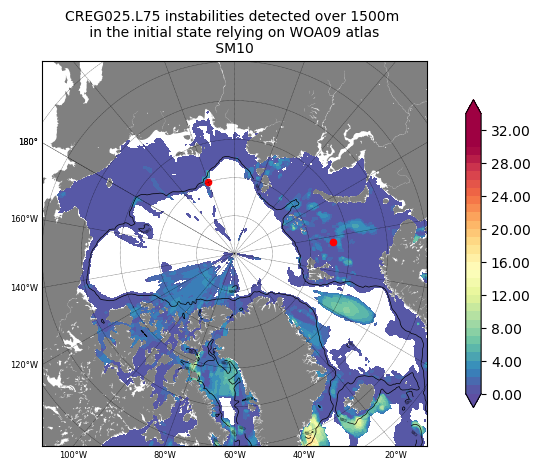

In [24]:
plt.figure(figsize=(10,5))
Arc_Bat(ztype='isol500')
m=Arc_plot(ds_init['nav_lon'],ds_init['nav_lat'],\
         xr.where(ds_init['Instab_sm']==0.,np.nan,ds_init['Instab_sm']),np.arange(35),[0.,30.],zmy_cmap='Spectral_r')
# Latitude & longitude
loc_x=140  ;  loc_y=80
x,y = m(loc_x,loc_y)
m.scatter(x,y,20,marker='o', color='r')

loc_x=37  ;  loc_y=77
x,y = m(loc_x,loc_y)
m.scatter(x,y,20,marker='o', color='r')
plt.title('CREG025.L75 instabilities detected over 1500m \n in the initial state relying on WOA09 atlas \n SM10 ',fontsize=10)
#plt.title('CREG025.L75 instabilities detected over 1500m \n in the initial state relying on WOA09 atlas',fontsize=10)

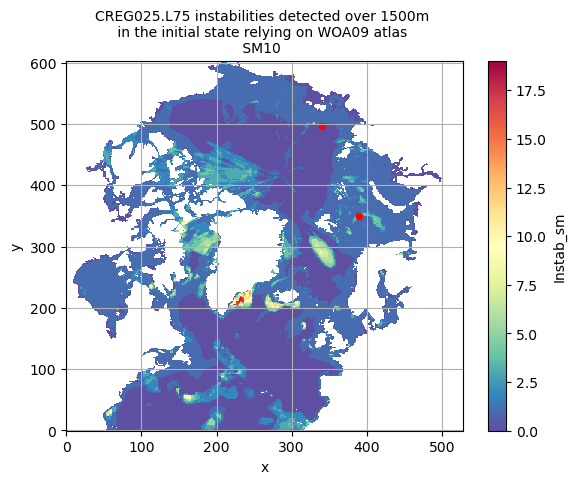

In [25]:
ds_init['Instab_sm'].plot(cmap='Spectral_r')
plt.scatter(340,497,20,marker='o', color='r')
plt.scatter(390,350,20,marker='o', color='r')
#plt.title('CREG025.L75 instabilities detected over 1500m \n in the initial state relying on WOA09 atlas',fontsize=10)
plt.title('CREG025.L75 instabilities detected over 1500m \n in the initial state relying on WOA09 atlas  \n SM10  ',fontsize=10)
plt.grid(True)

> # T/S Diagrams 

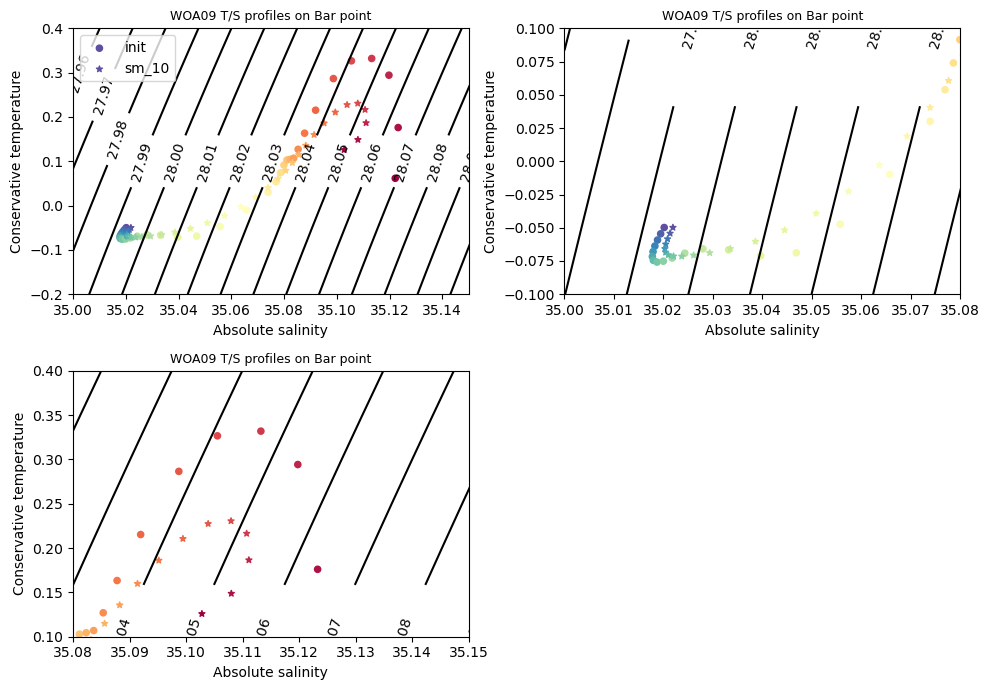

In [26]:
plt.figure(figsize=(10,7))

# Build the density contours 
temp=np.arange(-0.2,0.4,0.05) ; sal=np.arange(35.,35.2,0.02)
temp2D=np.tile(temp,(sal.size,1)).T
ztmp=np.reshape(sal,(1,sal.size))
sal2D=np.tile(ztmp,(temp.size,1))

sig0=gsw.density.sigma0(sal2D,temp2D)
sig0.shape


# Latitude & longitude
loc_x=390  ;  loc_y=350 ; filext='Bar'  # Barents

num_smooth=10
tsmo='sm_'+str(num_smooth)

cast_CT=ds_init['CT'].isel(y=loc_y,x=loc_x)
cast_SA=ds_init['SA'].isel(y=loc_y,x=loc_x)

cast_CT_sm=ds_init['CT_sm'].isel(y=loc_y,x=loc_x)
cast_SA_sm=ds_init['SA_sm'].isel(y=loc_y,x=loc_x)

# Profondeurs associées (on suppose que la coordonnée verticale s'appelle 'depth')
#profondeur = ds_woa09_z75['depth'].values
profondeur=np.arange(ds_init.sizes['nav_lev'])

plt.subplot(221)
CS=plt.contour(sal2D,temp2D,sig0,levels=20,colors='k')
plt.clabel(CS,CS.levels)
plt.scatter(cast_SA,cast_CT,20,marker='o',c=profondeur,label='init',cmap='Spectral_r')
plt.scatter(cast_SA_sm,cast_CT_sm,20,marker='*', c=profondeur,label=tsmo,cmap='Spectral_r')
plt.title('WOA09 T/S profiles on '+filext+' point',fontsize=9)
plt.ylabel('Conservative temperature')
plt.xlabel('Absolute salinity')
plt.xlim([35.,35.15])
plt.ylim([-0.2,0.4])

plt.legend(loc='upper left')
#plt.grid(True)

if True :
    plt.subplot(222)
    CS=plt.contour(sal2D,temp2D,sig0,levels=20,colors='k')
    plt.clabel(CS,CS.levels)
    plt.scatter(cast_SA,cast_CT,20,marker='o', c=profondeur,label='init',cmap='Spectral_r')
    plt.scatter(cast_SA_sm,cast_CT_sm,20,marker='*', c=profondeur, label=tsmo,cmap='Spectral_r')
    plt.title('WOA09 T/S profiles on '+filext+' point',fontsize=9)
    plt.ylabel('Conservative temperature')
    plt.xlabel('Absolute salinity')
    plt.xlim([35.,35.08])
    plt.ylim([-0.1,0.1])
    #plt.legend()
    #plt.grid(True)
if True :
    plt.subplot(223)
    CS=plt.contour(sal2D,temp2D,sig0,levels=20,colors='k')
    plt.clabel(CS,CS.levels)
    plt.scatter(cast_SA,cast_CT,20,marker='o',c=profondeur,label='init',cmap='Spectral_r')
    plt.scatter(cast_SA_sm,cast_CT_sm,20,marker='*', c=profondeur,label=tsmo,cmap='Spectral_r')
    plt.title('WOA09 T/S profiles on '+filext+' point',fontsize=9)
    plt.ylabel('Conservative temperature')
    plt.xlabel('Absolute salinity')
    plt.xlim([35.08,35.15])
    plt.ylim([0.1,0.4])
    #plt.legend()
    #plt.grid(True)
 
plt.tight_layout()

if False:
    plt.savefig('./WOA09_z75_smoothing_DiagTS_'+filext+'_'+tsmo+'.png',dpi=300)

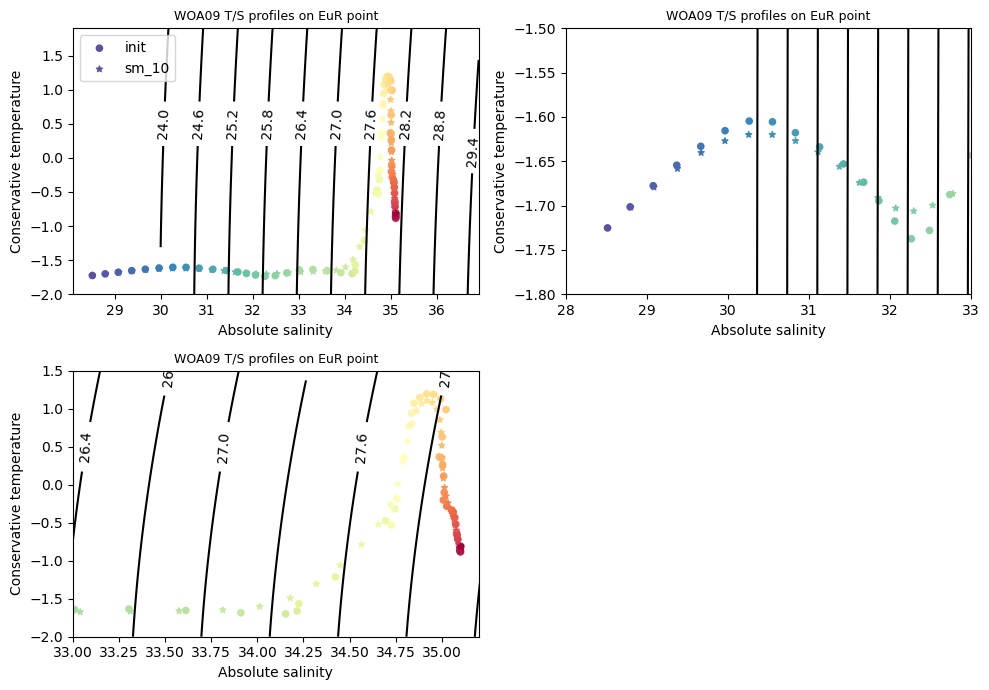

In [27]:
plt.figure(figsize=(10,7))


# Build the density contours 
temp=np.arange(-2.,2.,0.1) ; sal=np.arange(30.,37.,0.1)
temp2D=np.tile(temp,(sal.size,1)).T
ztmp=np.reshape(sal,(1,sal.size))
sal2D=np.tile(ztmp,(temp.size,1))

sig0=gsw.density.sigma0(sal2D,temp2D)
sig0.shape

# Latitude & longitude
loc_x=340  ;  loc_y=497 ; filext='EuR'  # Eurasia

num_smooth=10
tsmo='sm_'+str(num_smooth)

cast_CT=ds_init['CT'].isel(y=loc_y,x=loc_x)
cast_SA=ds_init['SA'].isel(y=loc_y,x=loc_x)

cast_CT_sm=ds_init['CT_sm'].isel(y=loc_y,x=loc_x)
cast_SA_sm=ds_init['SA_sm'].isel(y=loc_y,x=loc_x)

# Profondeurs associées (on suppose que la coordonnée verticale s'appelle 'depth')
#profondeur = ds_woa09_z75['depth'].values
profondeur=np.arange(ds_init.sizes['nav_lev'])

plt.subplot(221)
CS=plt.contour(sal2D,temp2D,sig0,levels=10,colors='k')
plt.clabel(CS,CS.levels)
plt.scatter(cast_SA,cast_CT,20,marker='o',c=profondeur,label='init',cmap='Spectral_r')
plt.scatter(cast_SA_sm,cast_CT_sm,20,marker='*', c=profondeur,label=tsmo,cmap='Spectral_r')
plt.title('WOA09 T/S profiles on '+filext+' point',fontsize=9)
plt.ylabel('Conservative temperature')
plt.xlabel('Absolute salinity')
#plt.xlim([34.6,35.3])

plt.legend(loc='upper left')
#plt.grid(True)

if True :
    plt.subplot(222)
    CS=plt.contour(sal2D,temp2D,sig0,levels=20,colors='k')
    plt.clabel(CS,CS.levels)
    plt.scatter(cast_SA,cast_CT,20,marker='o', c=profondeur,label='init',cmap='Spectral_r')
    plt.scatter(cast_SA_sm,cast_CT_sm,20,marker='*', c=profondeur, label=tsmo,cmap='Spectral_r')
    plt.title('WOA09 T/S profiles on '+filext+' point',fontsize=9)
    plt.ylabel('Conservative temperature')
    plt.xlabel('Absolute salinity')
    plt.xlim([28.,33.])
    plt.ylim([-1.8,-1.5])
    #plt.legend()
    #plt.grid(True)
if True :
    plt.subplot(223)
    CS=plt.contour(sal2D,temp2D,sig0,levels=20,colors='k')
    plt.clabel(CS,CS.levels)
    plt.scatter(cast_SA,cast_CT,20,marker='o',c=profondeur,label='init',cmap='Spectral_r')
    plt.scatter(cast_SA_sm,cast_CT_sm,20,marker='*', c=profondeur,label=tsmo,cmap='Spectral_r')
    plt.title('WOA09 T/S profiles on '+filext+' point',fontsize=9)
    plt.ylabel('Conservative temperature')
    plt.xlabel('Absolute salinity')
    plt.xlim([33,35.2])
    plt.ylim([-2.,1.5])
    #plt.legend()
    #plt.grid(True)
 
plt.tight_layout()

if False:
    plt.savefig('./WOA09_z75_smoothing_DiagTS_'+filext+'_'+tsmo+'.png',dpi=300)

>> # Compare with the CDFTOOLS method used to compute N2 
CAUTION: the field has been interpolated at T-point

In [28]:
DATA_PATH='/data0/project/drakkar/CONFIGS/CREG025.L75/GRID/'
filein='CREG025.L75-NEMO420_OCEinit_N2.nc'
ds_N2init=xr.open_dataset(DATA_PATH+filein,drop_variables=["x", "y"])
ds_N2init

<xarray.Dataset>
Dimensions:       (y: 603, x: 528, depth: 75, time_counter: 1)
Coordinates:
  * depth         (depth) float32 0.5058 0.5058 0.5058 ... 0.5058 0.5058 0.5058
  * time_counter  (time_counter) float32 0.0
Dimensions without coordinates: y, x
Data variables:
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    vobn2         (time_counter, depth, y, x) float32 ...
Attributes:
    start_date:        -1
    output_frequency:  N/A
    CONFIG:            N/A
    CASE:              N/A
    history:           Partial step computation

In [31]:
# Build a 2D map to see how many instabilities occur on each water column
num_DINT_N2=np.where(ds_N2init['vobn2'].isel(time_counter=0).values < 0.,1.,0.)
# Remove the grid points in the a pseudo ML
num_DINT_N2[0:10,:,:]=0. 
# Remove the grid points below 1500m to make a clean comparison with WOA09
num_DINT_N2[50::,:,:]=0. 
ds_N2init['Instab']=(('y','x'),np.sum(num_DINT_N2,axis=0))
ds_N2init['Instab']=xr.where(tmask2D==0,np.nan,ds_N2init['Instab'])

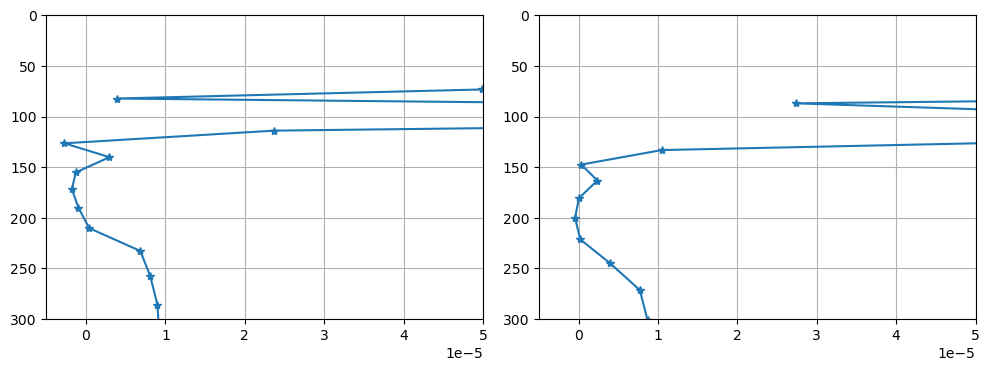

In [33]:
plt.figure(figsize=(10,7))

loc_x=340  ;  loc_y=497

if False:
    plt.subplot(221)
    ds_init['votemper'].isel(x=loc_x,y=loc_y).plot(y='nav_lev',marker='*')
    ds_init['CT'].isel(x=loc_x,y=loc_y).plot(y='nav_lev')
    plt.ylim([300,0.])
    plt.grid(True)

    plt.subplot(222)
    ds_init['vosaline'].isel(x=loc_x,y=loc_y).plot.line(y='nav_lev',marker='*')
    ds_init['SA'].isel(x=loc_x,y=loc_y).plot(y='nav_lev')
    plt.xlim([28,35])
    plt.ylim([300,0.])
    plt.grid(True)

if True:
    plt.subplot(223)
    plt.plot(N2[:,loc_y,loc_x],ds_DIN['depthw'].isel(depthw=slice(0,74)),marker='*')
    plt.xlim([-0.5e-5,5e-5])
    plt.ylim([300,0.])
    plt.grid(True)

if True:
    plt.subplot(224)
    plt.plot(ds_N2init['vobn2'][0,:,loc_y,loc_x],ds_DINT['deptht'],marker='*')
    plt.xlim([-0.5e-5,5e-5])
    plt.ylim([300,0.])
    plt.grid(True)

plt.tight_layout()

Text(0.5, 1.0, 'CREG025.L75 instabilities detected over 1500m in the initial state relying on WOA09 atlas \n computed using the N2 from cdfbn2 script')

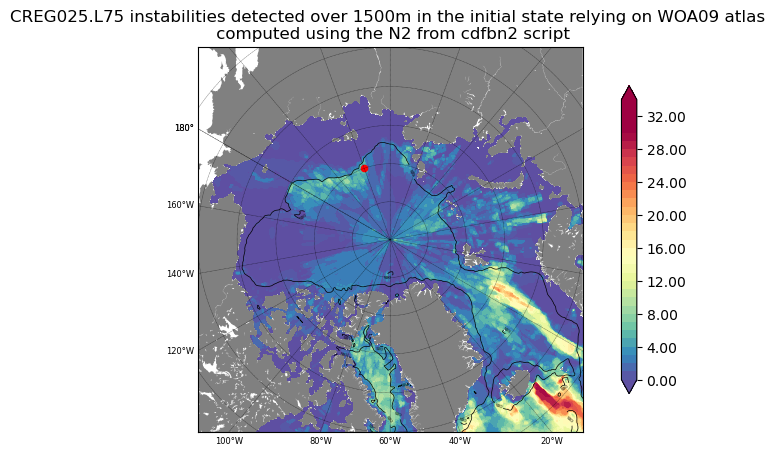

In [34]:
plt.figure(figsize=(10,5))
Arc_Bat(ztype='isol500')
m=Arc_plot(ds_init['nav_lon'],ds_init['nav_lat'],\
         ds_N2init['Instab'],np.arange(35),[0.,30.],zmy_cmap='Spectral_r')
#         xr.where(ds_N2init['Instab']==0.,np.nan,ds_N2init['Instab']),np.arange(35),[0.,30.],zmy_cmap='Spectral_r')
# Latitude & longitude
loc_x=140  ;  loc_y=80
x,y = m(loc_x,loc_y)
m.scatter(x,y,20,marker='o', color='r')
plt.title('CREG025.L75 instabilities detected over 1500m in the initial state relying on WOA09 atlas \n computed using the N2 from cdfbn2 script')


Text(0.5, 1.0, 'CREG025.L75 instabilities detected over 1500m in the initial state relying on WOA09 atlas \n computed using the N2 from cdfbn2 script and not the GSW package')

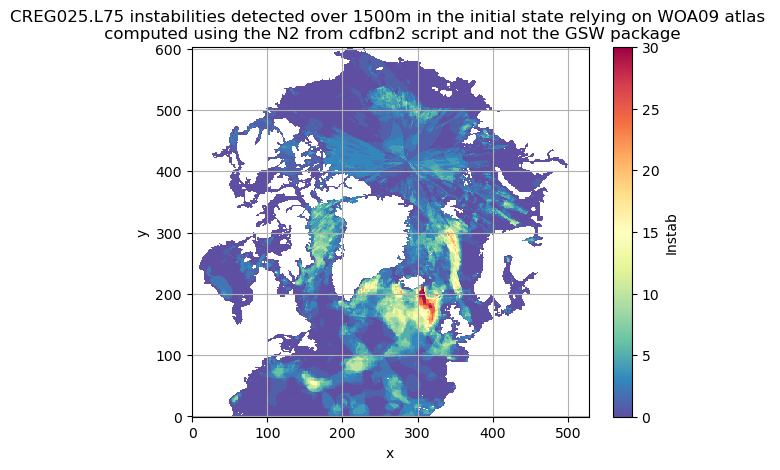

In [46]:
ds_N2init['Instab'].plot(cmap='Spectral_r')
plt.grid(True)
plt.title('CREG025.L75 instabilities detected over 1500m in the initial state relying on WOA09 atlas \n computed using the N2 from cdfbn2 script and not the GSW package')


>>>>  # After 1 simulated month 

In [28]:
CASE='NEMO420DIN'   ; freq='1m'

year=1979
DATA_PATH='/data0/project/drakkar/CONFIGS/CREG025.L75/TMPDIR/'
ds_DIN = xr.open_dataset(DATA_PATH+'CREG025.L75-'+CASE+'_y'+str(year)+'m01.'+freq+'_gridW_SM10.nc')  
ds_DINT= xr.open_dataset(DATA_PATH+'CREG025.L75-'+CASE+'_y'+str(year)+'m01.'+freq+'_gridT_SM10.nc',drop_variables=['nav_lat','nav_lon'])  
ds_DINT.coords['nav_lat']=fieldbat['nav_lat']
ds_DINT.coords['nav_lon']=fieldbat['nav_lon']
ds_DINT

<xarray.Dataset>
Dimensions:               (deptht: 75, axis_nbounds: 2, time_counter: 1,
                           y: 603, x: 528)
Coordinates:
  * deptht                (deptht) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    time_centered         (time_counter) object ...
  * time_counter          (time_counter) object 1979-01-16 12:00:00
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
Dimensions without coordinates: axis_nbounds, y, x
Data variables:
    deptht_bounds         (deptht, axis_nbounds) float32 ...
    time_centered_bounds  (time_counter, axis_nbounds) object ...
    time_counter_bounds   (time_counter, axis_nbounds) object ...
    e3t                   (time_counter, deptht, y, x) float32 ...
    votemper              (time_counter, deptht, y, x) float32 ...
    vosaline              (time_counter, deptht, y, x) float32 ...
    ssh                   (time_counter, y, x) float32 ...
    mldkz5                (time_counter, y, x) float32 ...
    mldr10_1              (time_counter, y, x) float32 ...
    rhop_sig0             (time_counter, deptht, y, x) float32 ...
    botpres               (time_counter, y, x) float32 ...
Attributes:
    name:              /home1/scratch/ctalandi/CREG025.L75-NEMO420DIN-XIOS.1/...
    description:       ocean T grid variables
    title:             ocean T grid variables
    Conventions:       CF-1.6
    timeStamp:         2025-Apr-30 08:55:12 GMT
    uuid:              28f95811-5b55-409e-98a1-378b88e0cc51
    start_date:        19790101
    output_frequency:  1mo
    CONFIG:            CREG025.L75
    CASE:              NEMO420DIN

In [29]:
ds_DINT=ds_DINT.rename({'deptht':'nav_lev'})

In [30]:
#pressure=pressure.rename({'nav_lev':'deptht'})
ds_DINT['SA']=gsw.conversions.SA_from_SP(ds_DINT['vosaline'],pressure,ds_DINT['nav_lon'],ds_DINT['nav_lat'])
ds_DINT['CT']=gsw.conversions.CT_from_pt(ds_DINT['SA'],ds_DINT['votemper'])

In [31]:
# Compute the Brunt-Vaissalla frequency
DINT_N2,p_imd=gsw.Nsquared(ds_DINT['SA'].isel(time_counter=0).values,\
                           ds_DINT['CT'].isel(time_counter=0).values,\
                           pressure,axis=0)

In [32]:
# Build a 2D map to see how many instabilities occur on each water column
num_DINT_N2=np.where(DINT_N2 < 0.,1.,0.)
# Remove the grid points in the a pseudo ML
num_DINT_N2[0:10,:,:]=0. 
# Remove the grid points below 1500m to make a clean comparison with WOA09
num_DINT_N2[50::,:,:]=0. 
ds_DINT['Instab']=(('y','x'),np.sum(num_DINT_N2,axis=0))
ds_DINT['Instab']=xr.where(tmask2D==0,np.nan,ds_DINT['Instab'])

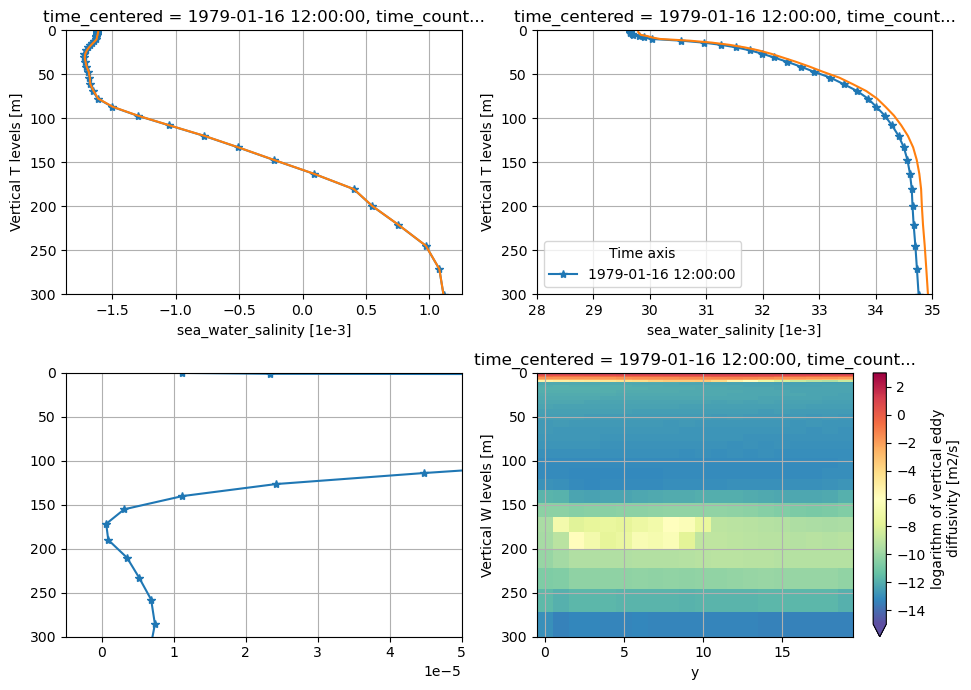

In [33]:
plt.figure(figsize=(10,7))

loc_x=340  ;  loc_y=497

plt.subplot(221)
ds_DINT['votemper'].isel(x=loc_x,y=loc_y).plot(y='nav_lev',marker='*')
ds_DINT['CT'].isel(x=loc_x,y=loc_y).plot(y='nav_lev')
plt.ylim([300,0.])
plt.grid(True)

plt.subplot(222)
ds_DINT['vosaline'].isel(x=loc_x,y=loc_y).plot.line(y='nav_lev',marker='*')
ds_DINT['SA'].isel(x=loc_x,y=loc_y).plot(y='nav_lev')
plt.xlim([28,35])
plt.ylim([300,0.])
plt.grid(True)

if True:
    plt.subplot(223)
    plt.plot(DINT_N2[:,loc_y,loc_x],ds_DIN['depthw'].isel(depthw=slice(0,74)),marker='*')
    plt.xlim([-0.5e-5,5e-5])
    plt.ylim([300,0.])
    plt.grid(True)

if True:
    plt.subplot(224)
    #ds_DIN['logavt'].isel(x=loc_x,y=loc_y).plot.line(y='depthw',marker='*')
    ds_DIN['logavt'].isel(x=340,y=slice(480,500)).plot(y='depthw',vmin=-15.,vmax=3.,cmap='Spectral_r')
    #plt.xlim([-15,4])
    plt.ylim([300,0.])
    plt.grid(True)

if False:
    plt.subplot(224)
    ds_init['sigma0'].isel(x=loc_x,y=loc_y).plot.line(y='nav_lev',marker='*')
    plt.xlim([27.6,28])
    plt.ylim([300,0.])
    plt.grid(True)

plt.tight_layout()

Text(0.5, 1.0, 'CREG025.L75 instabilities detected over 1500m using January monthly mean 1979 ')

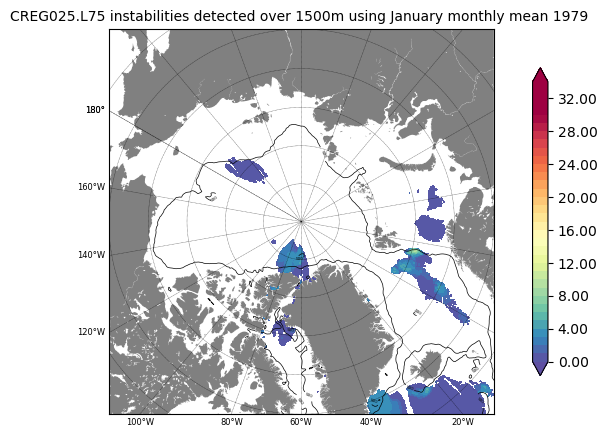

In [34]:
plt.figure(figsize=(10,5))
Arc_Bat(ztype='isol500')
Arc_plot(ds_DINT['nav_lon'],ds_DINT['nav_lat'],\
         xr.where(ds_DINT['Instab']==0.,np.nan,ds_DINT['Instab']),np.arange(35),[0.,30.],zmy_cmap='Spectral_r')
plt.title('CREG025.L75 instabilities detected over 1500m using January monthly mean 1979 ',fontsize=10)

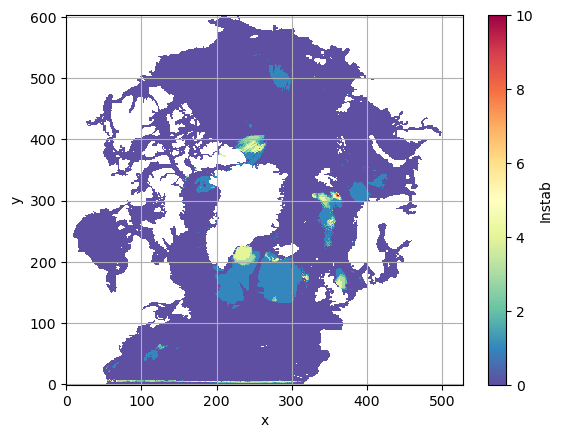

In [35]:
ds_DINT['Instab'].plot(cmap='Spectral_r')
plt.grid(True)

>>>> # After 12 months

In [36]:
CASE='NEMO420DIN'   ; freq='1m'

year=1979
DATA_PATH='/data0/project/drakkar/CONFIGS/CREG025.L75/TMPDIR/'
ds_DIN = xr.open_dataset(DATA_PATH+'CREG025.L75-'+CASE+'_y'+str(year)+'m12.'+freq+'_gridW_SM10.nc')  
ds_DINT= xr.open_dataset(DATA_PATH+'CREG025.L75-'+CASE+'_y'+str(year)+'m12.'+freq+'_gridT_SM10.nc',drop_variables=['nav_lat','nav_lon'])  
ds_DINT.coords['nav_lat']=fieldbat['nav_lat']
ds_DINT.coords['nav_lon']=fieldbat['nav_lon']
ds_DINT

<xarray.Dataset>
Dimensions:               (deptht: 75, axis_nbounds: 2, time_counter: 1,
                           y: 603, x: 528)
Coordinates:
  * deptht                (deptht) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    time_centered         (time_counter) object ...
  * time_counter          (time_counter) object 1979-12-16 12:00:00
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
Dimensions without coordinates: axis_nbounds, y, x
Data variables:
    deptht_bounds         (deptht, axis_nbounds) float32 ...
    time_centered_bounds  (time_counter, axis_nbounds) object ...
    time_counter_bounds   (time_counter, axis_nbounds) object ...
    e3t                   (time_counter, deptht, y, x) float32 ...
    votemper              (time_counter, deptht, y, x) float32 ...
    vosaline              (time_counter, deptht, y, x) float32 ...
    ssh                   (time_counter, y, x) float32 ...
    mldkz5                (time_counter, y, x) float32 ...
    mldr10_1              (time_counter, y, x) float32 ...
    rhop_sig0             (time_counter, deptht, y, x) float32 ...
    botpres               (time_counter, y, x) float32 ...
Attributes:
    name:              /home1/scratch/ctalandi/CREG025.L75-NEMO420DIN-XIOS.1/...
    description:       ocean T grid variables
    title:             ocean T grid variables
    Conventions:       CF-1.6
    timeStamp:         2025-Apr-30 14:01:26 GMT
    uuid:              f2d9edf7-744b-41fb-b6a4-b3b4c323016c
    start_date:        19790101
    output_frequency:  1mo
    CONFIG:            CREG025.L75
    CASE:              NEMO420DIN

In [37]:
# Define a pressure from depth
pressure=gsw.p_from_z(-ds_DINT['deptht'],ds_DIN['nav_lat'])

#pressure=pressure.rename({'depthw':'deptht'})
ds_DINT['SA']=gsw.conversions.SA_from_SP(ds_DINT['vosaline'],pressure,ds_DINT['nav_lon'],ds_DINT['nav_lat'])
ds_DINT['CT']=gsw.conversions.CT_from_pt(ds_DINT['SA'],ds_DINT['votemper'])


# Compute the Brunt-Vaissalla frequency
DINT_N2,p_imd=gsw.Nsquared(ds_DINT['SA'].isel(time_counter=0).values,\
                           ds_DINT['CT'].isel(time_counter=0).values,\
                           pressure,axis=0)

# Build a 2D map to see how many instabilities occur on each water column
num_DINT_N2=np.where(DINT_N2 < 0.,1.,0.)
# Remove the grid points in the a pseudo ML
num_DINT_N2[0:10,:,:]=0. 
# Remove the grid points below 1500m to make a clean comparison with WOA09
num_DINT_N2[50::,:,:]=0. 
ds_DINT['Instab']=(('y','x'),np.sum(num_DINT_N2,axis=0))
ds_DINT['Instab']=xr.where(tmask2D==0,np.nan,ds_DINT['Instab'])

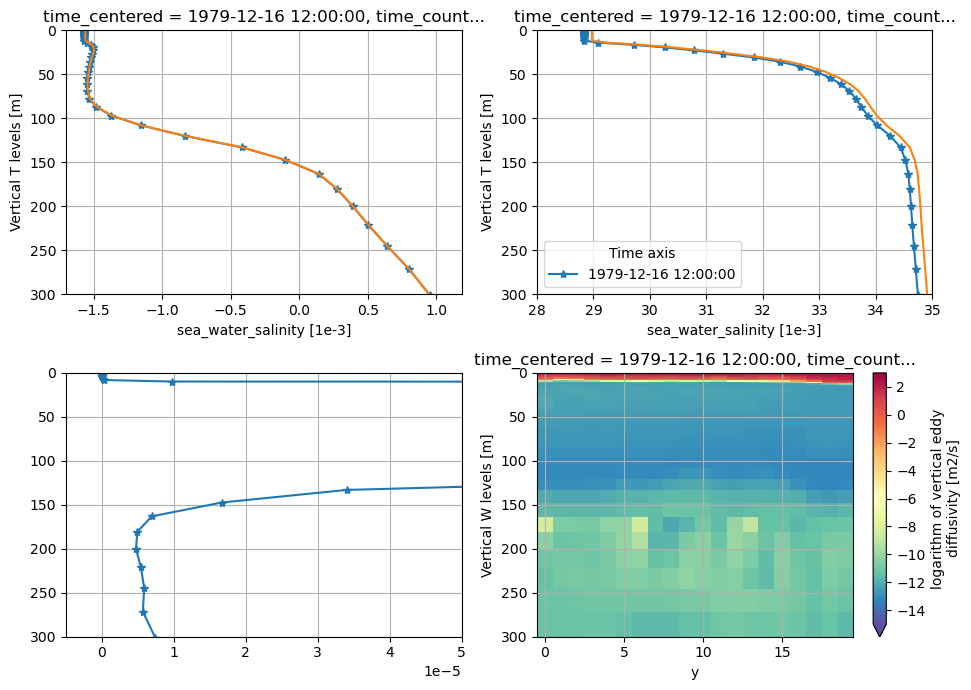

In [38]:
plt.figure(figsize=(10,7))

loc_x=340  ;  loc_y=497

plt.subplot(221)
ds_DINT['votemper'].isel(x=loc_x,y=loc_y).plot(y='deptht',marker='*')
ds_DINT['CT'].isel(x=loc_x,y=loc_y).plot(y='deptht')
plt.ylim([300,0.])
plt.grid(True)

plt.subplot(222)
ds_DINT['vosaline'].isel(x=loc_x,y=loc_y).plot.line(y='deptht',marker='*')
ds_DINT['SA'].isel(x=loc_x,y=loc_y).plot(y='deptht')
plt.xlim([28,35])
plt.ylim([300,0.])
plt.grid(True)

if True:
    plt.subplot(223)
    plt.plot(DINT_N2[:,loc_y,loc_x],ds_DINT['deptht'].isel(deptht=slice(0,74)),marker='*')
    plt.xlim([-0.5e-5,5e-5])
    plt.ylim([300,0.])
    plt.grid(True)

if True:
    plt.subplot(224)
    #ds_DIN['logavt'].isel(x=loc_x,y=loc_y).plot.line(y='depthw',marker='*')
    ds_DIN['logavt'].isel(x=340,y=slice(480,500)).plot(y='depthw',vmin=-15.,vmax=3.,cmap='Spectral_r')
    #plt.xlim([-15,4])
    plt.ylim([300,0.])
    plt.grid(True)

if False:
    plt.subplot(224)
    ds_init['sigma0'].isel(x=loc_x,y=loc_y).plot.line(y='nav_lev',marker='*')
    plt.xlim([27.6,28])
    plt.ylim([300,0.])
    plt.grid(True)

plt.tight_layout()    

Text(0.5, 1.0, 'CREG025.L75 instabilities detected over 1500m using December monthly mean 1979 ')

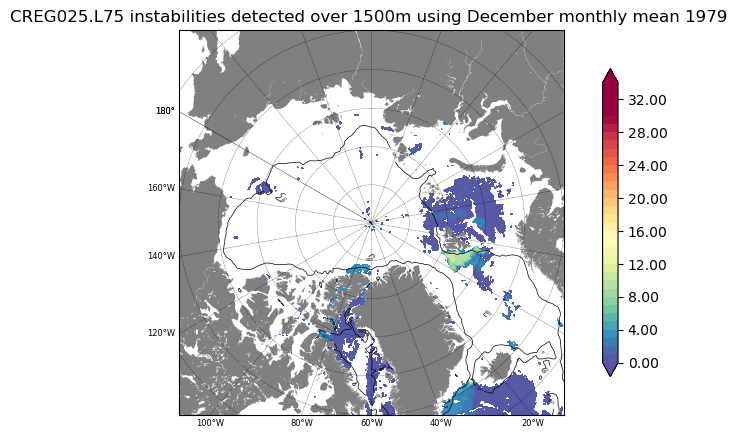

In [39]:
plt.figure(figsize=(10,5))
Arc_Bat(ztype='isol500')
Arc_plot(ds_DINT['nav_lon'],ds_DINT['nav_lat'],\
         xr.where(ds_DINT['Instab']==0.,np.nan,ds_DINT['Instab']),np.arange(35),[0.,30.],zmy_cmap='Spectral_r')
plt.title('CREG025.L75 instabilities detected over 1500m using December monthly mean 1979 ')

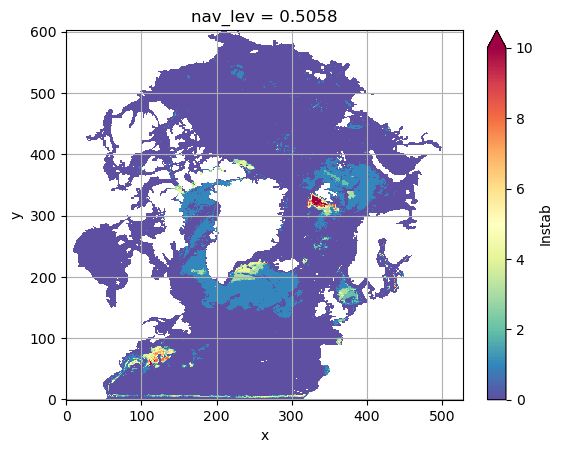

In [40]:
ds_DINT['Instab'].plot(cmap='Spectral_r',vmax=10)
plt.grid(True)
    

# Plot on a map the mooring location

In [14]:
bx_SVAL={'name':'SVA','lon_min':325,'lon_max':325,'lat_min':350,'lat_max':350,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_BANN={'name':'BAN','lon_min':347,'lon_max':347,'lat_min':400,'lat_max':400,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_AANN={'name':'AAN','lon_min':354,'lon_max':354,'lat_min':425,'lat_max':425,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_KARA={'name':'KAR','lon_min':355,'lon_max':355,'lat_min':450,'lat_max':450,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_ULAP={'name':'ULA','lon_min':364,'lon_max':364,'lat_min':478,'lat_max':478,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_LAPT={'name':'LAP','lon_min':355,'lon_max':355,'lat_min':500,'lat_max':500,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_BGYR={'name':'BFG','lon_min':200,'lon_max':200,'lat_min':500,'lat_max':500,'tmin':-2.,'tmax':2.,'smin':28.,'smax':35.}
bx_GINS={'name':'GIN','lon_min':355,'lon_max':355,'lat_min':310,'lat_max':310,'tmin':-2.,'tmax':2.,'smin':28.,'smax':35.}
bx_MIKE={'name':'MIB','lon_min':356,'lon_max':356,'lat_min':237,'lat_max':237,'tmin':-2.,'tmax':2.,'smin':28.,'smax':35.}

In [9]:
LAPT_sec={'name':"Laptev" ,'jmin': 470,'jmax':520 ,'imin':340}
SANX_sec={'name':"Saint Anna",'imin': 320,'imax':370 ,'jmax':425}

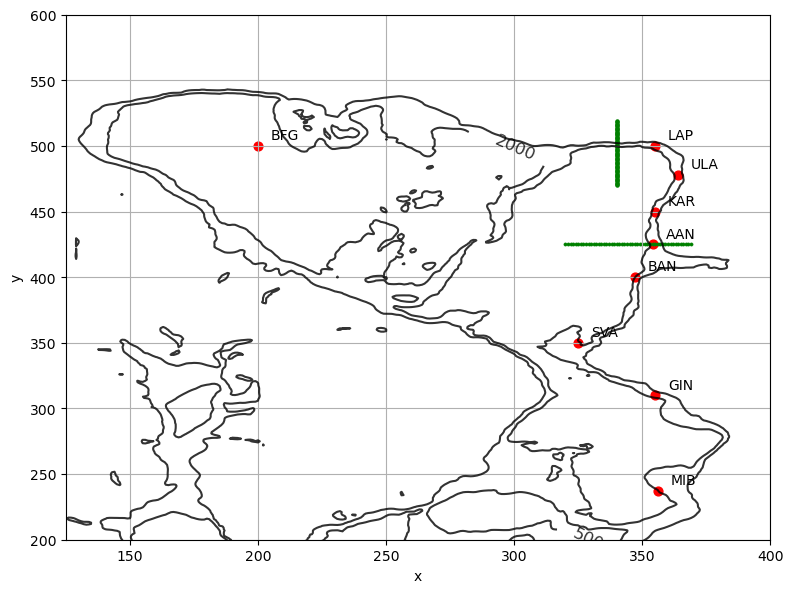

In [23]:
plt.figure(figsize=(20,15))
plt.subplot(221)
CS=fieldbat['bathy_meter'].isel(t=0).plot.contour(levels=[500.,2000.],colors='k',alpha=0.8)
plt.clabel(CS,fontsize=12)
plt.ylim([200,600])
plt.xlim([125,400])
All_box=[bx_SVAL,bx_BANN,bx_AANN,bx_KARA,bx_ULAP,bx_LAPT,bx_BGYR,bx_GINS,bx_MIKE]
for box in All_box:
    plt.scatter(box['lon_min'],box['lat_min'],40,marker='o', color='r')
    plt.text(box['lon_min']+5,box['lat_min']+5,box['name'])
plt.grid(True)
# Plot the sections
if True:
    All_sec=[SANX_sec]
    for box in All_sec:
            #################
            # ZONAL SECTIONS
            #################
            ji=box['imin'] ;   jj=box['jmax']
            while ji <= box['imax']-1 :
                    plt.scatter(ji,jj,5,linewidth=0.5,color='g')
                    ji+=1

    All_sec=[LAPT_sec]
    for box in All_sec:
            #################
            # MERIDIONAL SECTIONS
            #################
            jj=box['jmin'] ;       ji=box['imin']
            while jj <= box['jmax']-1 :
                    plt.scatter(ji,jj,5,linewidth=1,color='g')
                    jj+=1
